In [8]:
import pandas
import numpy
import statistics
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import model_selection


def seleccionar_caracteristicas_sffs(datos_csv,names=[],umbral = 10, n_exp = 10, cv = 10, metrica ='balanced_accuracy'):

    atributos = names

    if(len(atributos)==0):

        atributos = list(datos_csv.columns)
        atributos.__delitem__(-1)

    if metrica == None:
        metrica = 'balanced_accuracy'

    result = aplicar_SFFS(datos_csv,atributos,umbral,n_exp,cv,metrica)

    return result

def seleccionar_caracteristicas_sfs(datos_csv,names=[],umbral = 10, n_exp = 10, cv = 10, metrica = 'balanced_accuracy' ):

    atributos = names

    if(len(atributos)==0):

        atributos = list(datos_csv.columns)
        atributos.__delitem__(-1)

    if metrica == None:
        metrica = 'balanced_accuracy'

    result = aplicar_SFS(datos_csv,atributos,umbral,n_exp,cv,metrica)

    return result

def aplicar_validacion_cruzada(datos, variables, n_exp, cv=10,metrica ='balanced_accuracy' ):
    # 1. Seleccionar del conjunto de datos de entrada, el subconjunto de columnas (variables) que queremos evaluar.
    lista_atributos = []

    for columna in variables:
        lista_atributos.append(datos[columna])

    atributos_escogidos = pandas.DataFrame(lista_atributos)
    atributos_escogidos = atributos_escogidos.transpose()

    objetivo = datos.iloc[:, -1]

    # Usaremos la implementación de árboles de decisión como algoritmo de aprendizaje
    clf = tree.DecisionTreeClassifier()
    clf = clf.fit(atributos_escogidos, objetivo)

    array_scores = []

    # 2. Repetir N_Exp veces y promediar el resultado
    for x in range(0, n_exp):
        # 2.1 Realizar experimento de validacion cruzada (promedio el resultado con statistics.mean)
        array_scores.append(statistics.mean(
            model_selection.cross_val_score(clf, atributos_escogidos, objetivo, cv=cv, scoring=metrica)))

    # 3. Devolver el resultado promedio
    return statistics.mean(array_scores)

def aplicar_SFS(datos,variables, D = 10, n_exp = 10,cv = 10, metrica = 'balanced_accuracy'):

    atributos = []
    atributos.extend(variables)

    solucion_actual = []

    column_names = ["MejorSolucionTemporal", "Tamaño", "Rendimiento"]
    result = pandas.DataFrame(columns=column_names)

    K = 0  # Contador de iteraciones o de variables seleccionadas en cada iteración

    while K < D:

        rendimiento_s_t = {}

        for variable in atributos:

            solucion_temporal = []

            # Por cada variable V del conjunto original de variables que no se encuentre en SolucionActual ni en Añadidos
            if (not solucion_actual.__contains__(variable) ):

                # 1.1 SolucionTemporal = SolucionActual + V
                if len(solucion_actual) > 0:
                    solucion_temporal.extend(solucion_actual)

                solucion_temporal.append(variable)

                # 1.2 Evaluar SolucionTemporal y guardar su rendimiento
                score = aplicar_validacion_cruzada(datos, solucion_temporal, n_exp, cv, metrica)
                rendimiento_s_t.__setitem__(score, solucion_temporal)
                result.loc[len(result)] = [frozenset(solucion_temporal), len(solucion_temporal), score]

         # 2. Seleccionar la mejor SolucionTemporal y hacer SolucionActual = MejorSolucionTemporal

        mejor_score_añadir = max(rendimiento_s_t.keys())
        solucion_actual = rendimiento_s_t[mejor_score_añadir]

        K = K + 1

    result_df = result.drop_duplicates(subset=['MejorSolucionTemporal','Tamaño'])

    return result_df.sort_values(by=['Rendimiento'], ascending=False)


def aplicar_SFFS(datos,variables, umbral=10,n_exp=10, cv=10, metrica ='balanced_accuracy'):

    atributos = list(variables)
    solucion_actual = []
    añadidos = []
    eliminados = []
    K = 0

    column_names = ["MejorSolucionTemporal", "Tamaño", "Rendimiento"]

    result = pandas.DataFrame(columns=column_names)

    while (K < umbral and len(variables) != len(añadidos)):

        rendimiento_s_t = {}            # Diccionario <score,solucionTemporal>
        rendimiento_s_t_borrar = {}     # Diccionario <score,solucionTemporal>

        #Condicion de parada: Comenzamos a contar K cuando añadidos esté lleno, mientras no lo esté, K = 0
        if len(variables) != len(añadidos):
            K = 0


        # 1. Seleccionar la mejor variable a añadir a Solucion Actual
        for variable in atributos:

            solucion_temporal = []

            # Por cada variable V del conjunto original de variables que no se encuentre en SolucionActual ni en Añadidos
            if (not solucion_actual.__contains__(variable) and not añadidos.__contains__(variable)):

                # 1.1 SolucionTemporal = SolucionActual + V
                if len(solucion_actual) > 0:
                    solucion_temporal.extend(solucion_actual)

                solucion_temporal.append(variable)

                # 1.2 Evaluar SolucionTemporal y guardar su rendimiento
                score = aplicar_validacion_cruzada(datos, solucion_temporal, n_exp, cv,metrica)
                rendimiento_s_t.__setitem__(score, solucion_temporal)
                result.loc[len(result)] = [frozenset(solucion_temporal),len(solucion_temporal),score]

        # 2. Seleccionar la mejor SolucionTemporal y hacer SolucionActual = MejorSolucionTemporal

        mejor_score_añadir = max(rendimiento_s_t.keys())
        solucion_actual = rendimiento_s_t[mejor_score_añadir]

        # 3. Actualizar Añadidos: Añadimos a esta lista la nueva variable añadidos a SolucionActual

        for solucion in solucion_actual:
            if not añadidos.__contains__(solucion):
                añadidos.append(solucion)

        # 4. Seleccionar la peor variable para eliminar de SolucionActual.

        if len(solucion_actual) > 1:

            #Creo un diccionario auxiliar para acceder a la variable a borrar
            dic_aux = {}

            for variable in solucion_actual :

                solucion_temporal = []

                #Por cada variable V de solucion_actual que NO se encuentre en eliminados
                if not eliminados.__contains__(variable):

                    #4.1 SolucionTemporal = SolucionActual - V
                    solucion_actual_copy = []
                    solucion_actual_copy.extend(solucion_actual)
                    solucion_actual_copy.remove(variable)
                    solucion_temporal = solucion_actual_copy

                    # 4.2 Evaluar SolucionTemporal y guardar su rendimiento
                    score = aplicar_validacion_cruzada(datos, solucion_temporal, n_exp, cv,metrica)
                    rendimiento_s_t_borrar.__setitem__(score, solucion_temporal)
                    result.loc[len(result)] = [frozenset(solucion_temporal), len(solucion_temporal), score]

                    dic_aux.__setitem__(score,variable)


            # 5 Seleccionar la mejor solucionTemporal

            mejor_score_borrar = max(rendimiento_s_t_borrar.keys())

            if (mejor_score_borrar > mejor_score_añadir):

                # Si en alguna iteración una nueva variable es eliminada, entonces reseteamos el contador a cero.
                solucion_actual = rendimiento_s_t_borrar[mejor_score_borrar]
                eliminados.append(dic_aux[mejor_score_borrar])
                K=-1

            else:

                solucion_actual = rendimiento_s_t[mejor_score_añadir]

        K = K + 1

    result = result.drop_duplicates(subset=['MejorSolucionTemporal','Tamaño'])

    return result.sort_values(by=['Rendimiento'],ascending=False)

def plot_linea(dataframe):

    medias = []

    x = list(range(1, dataframe['Tamaño'].max() + 1))

    y = medias

    for i in x:
        df = dataframe[dataframe['Tamaño'] == i]

        medias.append(statistics.mean(df['Rendimiento'].values))

    plt.plot(x, y)
    plt.title('Evolucion de la capacidad predictiva en el conjunto de datos')
    plt.xlabel('Número de variables escogidas')
    plt.ylabel('Rendimiento medio')
    plt.show()

def plot_violin(dataframe):

    valores = []

    tamaños = list(range(1, dataframe['Tamaño'].max() + 1))

    for i in tamaños:

        df = dataframe[dataframe['Tamaño'] == i]

        valores.append(df['Rendimiento'].values)

    plt.violinplot(dataset=valores, positions=tamaños, vert= True)
    plt.title('Evolucion de la capacidad predictiva en el conjunto de datos')
    plt.xlabel('Número de variables escogidas')
    plt.ylabel('Rendimiento')
    plt.show()


                            MejorSolucionTemporal Tamaño  Rendimiento
88          (SibSp, Title, Is_Married, Sex, Deck)      5     0.816197
74                      (SibSp, Deck, Title, Sex)      4     0.816197
64             (SibSp, Title, Initial, Sex, Deck)      5     0.813824
57                  (SibSp, Title, Deck, Initial)      4     0.812913
73      (SibSp, Title, Initial, Is_Married, Deck)      5     0.812003
58             (SibSp, Deck, Initial, Is_Married)      4     0.811260
41                         (SibSp, Deck, Initial)      3     0.811260
48                    (SibSp, Deck, Initial, Sex)      4     0.811260
101  (SibSp, Title, Is_Married, Alone, Sex, Deck)      6     0.810924
86               (SibSp, Title, Alone, Sex, Deck)      5     0.810924


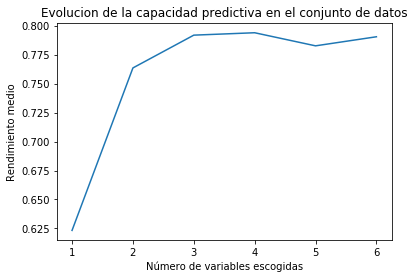

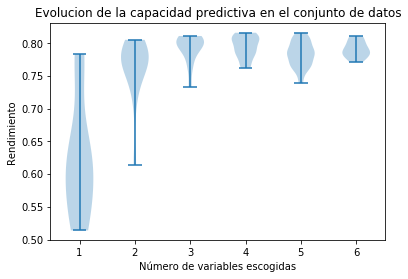

In [13]:
datos_csv = pandas.read_csv("titanic.csv") # <- Indicar aquí el csv del cual seleccionar sus características

names = [] #<- Indicar aquí los atributos a seleccionar (Todas las variables por defecto)

umbral = 10 #<- Indicar aquí el umbral para SFFS y SFS (10 por defecto)

n_exp = 1 # <- Número de repeticiones del experimento por validación cruzada. (10 por defecto)

cv = 3 #<-  Número de folds a considerar en la validación cruzada (10 por defecto).

metrica = None # <- Métrica de evaluación a usar ( ‘balanced_accuracy_score’ por defecto )

x = 10 #<- Indicar los x mejores conjuntos de características a mostrar


#Descomentar el método que queremos usar

solucion = seleccionar_caracteristicas_sffs(datos_csv,names,umbral,n_exp,cv,metrica)   #SFFS

#solucion = seleccionar_caracteristicas_sfs(datos_csv,names,umbral,n_exp,cv)           #SFS


print(solucion.head(x))

plot_linea(solucion)
plot_violin(solucion)

In [14]:
cd C:\Users\Javie\Onedrive\Escritorio\Universidad\IA\Trabajo


C:\Users\Javie\Onedrive\Escritorio\Universidad\IA\Trabajo
